### Step 1 – Extract

In [31]:

!pip install faker

In [32]:

# STEP 1: EXTRACT DATA
# Import required libraries
import pandas as pd        # For handling and manipulating tabular data
import numpy as np         # For generating random numbers and arrays
from faker import Faker    # For creating fake but realistic-looking data
from datetime import datetime, timedelta  # For working with dates

def generate_synthetic_data(num_rows=1000):
    """
    Generates synthetic retail sales data using Faker and NumPy.
    The data structure mimics the UCI Online Retail dataset.

    Parameters:
    ----------
    num_rows : int
        Number of rows (records) to generate. Default = 1000.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing the generated synthetic sales data.
    """

    # Initialize Faker object for creating fake values
    fake = Faker()

    # Container to store generated rows
    data = []

    # Define the start and end dates for random date generation
    start_date = datetime(2023, 8, 12)
    end_date = datetime(2025, 8, 12)

    # Calculate total number of days in the range for date randomization
    date_range = (end_date - start_date).days

    # Loop to generate each record
    for _ in range(num_rows):
        # Generate random invoice number (5 digits)
        invoice_no = fake.random_int(min=10000, max=99999)

        # Generate random stock code (two letters + three digits)
        stock_code = fake.bothify(text='??###')

        # Create a fake product description by combining two words
        description = fake.word().capitalize() + " " + fake.word().capitalize()

        # Generate a quantity between 1 and 50
        quantity = np.random.randint(1, 50)

        # Generate a random date within the given range
        invoice_date = start_date + timedelta(days=np.random.randint(0, date_range))

        # Generate a unit price between 1 and 100 (rounded to 2 decimal places)
        unit_price = round(np.random.uniform(1, 100), 2)

        # Random customer ID between 1 and 100 (100 unique customers)
        customer_id = np.random.randint(1, 101)

        # Generate a random country name
        country = fake.country()

        # Append the generated record to the list
        data.append([invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country])

    # Define column names similar to the original Online Retail dataset
    columns = ["InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country",]

    # Convert the list of records into a pandas DataFrame
    return pd.DataFrame(data, columns=columns)

# Generate and preview the synthetic dataset
df = generate_synthetic_data()

# Display the first 5 rows to verify data structure
print(df.head())


   InvoiceNo StockCode    Description  Quantity InvoiceDate  UnitPrice  \
0      71467     mL209  Arrive Window        35  2024-07-17      72.90   
1      15066     Ll688  Line Actually        31  2024-01-28      42.15   
2      44703     Ae358       Girl Two        21  2023-08-20      16.32   
3      71939     Ya034  Recently Bill        10  2024-08-23      23.82   
4      18812     qo515     Upon Ready        16  2025-04-28      52.76   

   CustomerID                               Country  
0          12                                  Fiji  
1          74                      Saint Barthelemy  
2          33  United States Minor Outlying Islands  
3          95                          Saint Helena  
4          79                                 Qatar  


In [33]:
 #  Save the generated dataset to CSV 
df.to_csv("synthetic_retail_data.csv", index=False)

### Step 2 – Transform
### Clean, calculate new fields, filter, and create dimension-like summaries.

In [34]:

# STEP 2: TRANSFORM DATA

# Ensure InvoiceDate is datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Add TotalSales column
df["TotalSales"] = df["Quantity"] * df["UnitPrice"]

# Remove outliers
df = df[(df["Quantity"] >= 0) & (df["UnitPrice"] > 0)]

# Filter last year (Aug 12, 2024 to Aug 12, 2025)
filter_start = datetime(2024, 8, 12)
filter_end = datetime(2025, 8, 12)
df_last_year = df[(df["InvoiceDate"] >= filter_start) & (df["InvoiceDate"] <= filter_end)]

# Create Customer summary
customer_summary = df_last_year.groupby("CustomerID").agg({
    "TotalSales": "sum",
    "Country": "first"
}).reset_index()

# Create Time dimension table
time_dim = df_last_year[["InvoiceDate"]].drop_duplicates().copy()
time_dim["Year"] = time_dim["InvoiceDate"].dt.year
time_dim["Month"] = time_dim["InvoiceDate"].dt.month
time_dim["Quarter"] = time_dim["InvoiceDate"].dt.quarter

print("Transformed Sales Data:\n", df_last_year.head())
print("\nCustomer Summary:\n", customer_summary.head())
print("\nTime Dimension:\n", time_dim.head())


Transformed Sales Data:
     InvoiceNo StockCode      Description  Quantity InvoiceDate  UnitPrice  \
3       71939     Ya034    Recently Bill        10  2024-08-23      23.82   
4       18812     qo515       Upon Ready        16  2025-04-28      52.76   
5       45934     eA168    Threat Others        31  2024-09-21      79.42   
10      14069     dK085  Mean Discussion        17  2025-02-09      93.82   
11      39512     Au037     Heavy Method        20  2025-07-03      71.44   

    CustomerID       Country  TotalSales  
3           95  Saint Helena      238.20  
4           79         Qatar      844.16  
5           87         Congo     2462.02  
10          47      Kiribati     1594.94  
11          43        Sweden     1428.80  

Customer Summary:
    CustomerID  TotalSales       Country
0           1     4756.42  Cook Islands
1           2     5906.93       Austria
2           3     5156.79        Canada
3           4     6368.02          Iran
4           5     5677.04       An

### Step 3 – Load
 Store the transformed data into SQLite database (retail_dw.db).

In [35]:

# STEP 3: LOAD DATA


import sqlite3

# Connect to SQLite database (creates file if it doesn't exist)
conn = sqlite3.connect("retail_dw.db")

# Load tables into database
df_last_year.to_sql("SalesFact", conn, if_exists="replace", index=False)
customer_summary.to_sql("CustomerDim", conn, if_exists="replace", index=False)
time_dim.to_sql("TimeDim", conn, if_exists="replace", index=False)

# Close connection
conn.close()

print("Data successfully loaded into retail_dw.db")


Data successfully loaded into retail_dw.db


In [36]:
### Step 4 – Combine into ETL Function


In [37]:
def run_etl():

    # EXTRACT PHASE
   
    print("🔹 Extracting...")
    # Generate synthetic retail data (mimics UCI Online Retail dataset)
    df = generate_synthetic_data()
    print(f"Rows Extracted: {len(df)}")  # Log total rows extracted

    # TRANSFORM PHASE
  
    print("🔹 Transforming...")

    # Convert InvoiceDate column to datetime for proper filtering and grouping
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

    # Calculate TotalSales as Quantity × UnitPrice
    df["TotalSales"] = df["Quantity"] * df["UnitPrice"]

    # Remove invalid rows where Quantity is negative or UnitPrice is zero/negative
    df = df[(df["Quantity"] >= 0) & (df["UnitPrice"] > 0)]

    # Define date range for "last year" sales (exam's reference date: Aug 12, 2025)
    filter_start = datetime(2024, 8, 12)
    filter_end = datetime(2025, 8, 12)

    # Filter dataset for only the sales in the last year
    df_last_year = df[(df["InvoiceDate"] >= filter_start) & (df["InvoiceDate"] <= filter_end)]

    # Create a Customer Dimension table:
    # - Group by CustomerID
    # - Aggregate total sales per customer
    # - Keep the first encountered country (assuming one per customer)
    customer_summary = df_last_year.groupby("CustomerID").agg({
        "TotalSales": "sum",
        "Country": "first"
    }).reset_index()

    # Create a Time Dimension table:
    # - Unique dates from last year's sales
    # - Extract Year, Month, and Quarter for analysis
    time_dim = df_last_year[["InvoiceDate"]].drop_duplicates().copy()
    time_dim["Year"] = time_dim["InvoiceDate"].dt.year
    time_dim["Month"] = time_dim["InvoiceDate"].dt.month
    time_dim["Quarter"] = time_dim["InvoiceDate"].dt.quarter

    print(f"Rows after transform: {len(df_last_year)}")  # Log rows after filtering

    # LOAD PHASE
   
    print("🔹 Loading into DB...")

    # Connect to (or create) SQLite database file retail_dw.db
    conn = sqlite3.connect("retail_dw.db")

    # Load fact table: SalesFact (last year's cleaned sales data)
    df_last_year.to_sql("SalesFact", conn, if_exists="replace", index=False)

    # Load dimension table: CustomerDim
    customer_summary.to_sql("CustomerDim", conn, if_exists="replace", index=False)

    # Load dimension table: TimeDim
    time_dim.to_sql("TimeDim", conn, if_exists="replace", index=False)

    # Close database connection
    conn.close()

    print(" ETL Complete!")  # Log completion message


# Run full ETL process
run_etl()


🔹 Extracting...
Rows Extracted: 1000
🔹 Transforming...
Rows after transform: 482
🔹 Loading into DB...
 ETL Complete!


### Step 4: the full ETL function

In [38]:
import sqlite3  # For database connection

def run_etl():
    """
    Runs the full ETL (Extract, Transform, Load) process for the synthetic retail dataset.
    Logs the number of rows processed at each stage.
    """


    # EXTRACT
  
    print("🔹 STEP 1: Extracting data...")
    df = generate_synthetic_data()  # Call our extraction function
    print(f" Extracted {len(df)} rows.")

   
    # TRANSFORM
 
    print("🔹 STEP 2: Transforming data...")

    # Convert InvoiceDate to datetime type
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

    # Create a new column for total sales value
    df["TotalSales"] = df["Quantity"] * df["UnitPrice"]

    # Remove invalid rows: Quantity < 0 or UnitPrice <= 0
    df = df[(df["Quantity"] >= 0) & (df["UnitPrice"] > 0)]

    # Filter for the last year (from 2024-08-12 to 2025-08-12)
    filter_start = datetime(2024, 8, 12)
    filter_end = datetime(2025, 8, 12)
    df_last_year = df[(df["InvoiceDate"] >= filter_start) & (df["InvoiceDate"] <= filter_end)]

    # Create Customer Dimension (summary)
    customer_summary = df_last_year.groupby("CustomerID").agg({
        "TotalSales": "sum",
        "Country": "first"  # Keep first country per customer
    }).reset_index()

    # Create Time Dimension (unique dates with year, month, quarter)
    time_dim = df_last_year[["InvoiceDate"]].drop_duplicates().copy()
    time_dim["Year"] = time_dim["InvoiceDate"].dt.year
    time_dim["Month"] = time_dim["InvoiceDate"].dt.month
    time_dim["Quarter"] = time_dim["InvoiceDate"].dt.quarter

    print(f" After transformation: {len(df_last_year)} rows in fact table.")


    # LOAD
  
    print("🔹 STEP 3: Loading data into SQLite database...")
    conn = sqlite3.connect("retail_dw.db")  # Create DB file
    df_last_year.to_sql("SalesFact", conn, if_exists="replace", index=False)  # Fact table
    customer_summary.to_sql("CustomerDim", conn, if_exists="replace", index=False)  # Customer dimension
    time_dim.to_sql("TimeDim", conn, if_exists="replace", index=False)  # Time dimension
    conn.close()
    print("Data successfully loaded into retail_dw.db")


    # LOG SUMMARY
    
    print("\n ETL PROCESS SUMMARY")
    print(f" - Rows Extracted: {len(df)}")
    print(f" - Rows After Transformation (Fact Table): {len(df_last_year)}")
    print(f" - CustomerDim Rows: {len(customer_summary)}")
    print(f" - TimeDim Rows: {len(time_dim)}")
    print(" ETL Completed Successfully!")

# Run the ETL process
run_etl()


🔹 STEP 1: Extracting data...
 Extracted 1000 rows.
🔹 STEP 2: Transforming data...
 After transformation: 505 rows in fact table.
🔹 STEP 3: Loading data into SQLite database...
Data successfully loaded into retail_dw.db

 ETL PROCESS SUMMARY
 - Rows Extracted: 1000
 - Rows After Transformation (Fact Table): 505
 - CustomerDim Rows: 100
 - TimeDim Rows: 273
 ETL Completed Successfully!


### Task 3: OLAP Queries
1. Roll-up: Total Sales by Country and Quarter


In [39]:
import sqlite3
import pandas as pd

# Connect to your SQLite database
conn = sqlite3.connect("retail_dw.db")

with sqlite3.connect("retail_dw.db") as conn:
    # Define SQL query to aggregate sales by country and quarter
    query_rollup_fixed = """
    SELECT 
        sf.Country,               -- Select country from SalesFact table
        td.Quarter,               -- Select quarter from TimeDim table
        SUM(sf.TotalSales) AS TotalSales  -- Calculate total sales for each group
    FROM SalesFact sf
    JOIN TimeDim td ON sf.InvoiceDate = td.InvoiceDate  -- Join on InvoiceDate to get quarter info
    GROUP BY sf.Country, td.Quarter                    -- Group results by country and quarter
    ORDER BY sf.Country, td.Quarter;                   -- Sort output by country and quarter
    """
    # Execute the query and load results into a DataFrame
    rollup_df = pd.read_sql_query(query_rollup_fixed, conn)
    # Print the roll-up results
    print("\n--- Roll-up: Total sales by Country & Quarter ---")
    print(rollup_df)


--- Roll-up: Total sales by Country & Quarter ---
            Country  Quarter  TotalSales
0       Afghanistan        3      529.00
1           Albania        1     1318.02
2           Albania        2      707.04
3           Albania        3     1596.18
4           Algeria        1     6729.67
..              ...      ...         ...
378  Western Sahara        1     4836.79
379           Yemen        2     1692.25
380           Yemen        3      323.34
381          Zambia        2     1052.88
382        Zimbabwe        1     1989.68

[383 rows x 3 columns]


 2️, Drill-down: Monthly Sales for a Specific Country

In [40]:
import pandas as pd  # Import pandas for DataFrame and SQL query handling

# Define the SQL query for drill-down analysis:
# This query retrieves monthly sales totals for a specific country from the SalesFact table.
# - SELECT td.Year, td.Month: Extracts the year and month from the TimeDim table.
# - SUM(sf.TotalSales) AS MonthlySales: Calculates the total sales for each month.
# - FROM SalesFact sf: Uses the sales fact table as the main source.
# - JOIN TimeDim td ON sf.InvoiceDate = td.InvoiceDate: Joins with the time dimension to get year/month.
# - WHERE sf.Country = ?: Filters results for the selected country (parameterized for safety).
# - GROUP BY td.Year, td.Month: Aggregates sales by year and month.
# - ORDER BY td.Year, td.Month: Sorts results chronologically.
query_drilldown_fixed = """
SELECT td.Year,
    td.Month,
    SUM(sf.TotalSales) AS MonthlySales
FROM SalesFact sf
JOIN TimeDim td ON sf.InvoiceDate = td.InvoiceDate
WHERE sf.Country = ?
GROUP BY td.Year, td.Month
ORDER BY td.Year, td.Month;
"""

# Execute the SQL query using pandas:
# - pd.read_sql_query runs the query and returns the result as a DataFrame.
# - conn is the SQLite connection object.
# - params=(country_name,) passes the selected country as a parameter to the query.
drilldown_df = pd.read_sql_query(query_drilldown_fixed, conn, params=(country_name,))

# Print the drill-down results for the selected country
print(f"\n--- Drill-down: Monthly sales for {country_name} ---")
print(drilldown_df)


--- Drill-down: Monthly sales for Belarus ---
   Year  Month  MonthlySales
0  2025      7       4577.77


3️, Slice: Total Sales by Category (focus on Electronics)

In [41]:
# OLAP Slice Query: Top 10 Product Descriptions by Total Sales

# The following code executes an OLAP "slice" query to find the top 10 product descriptions
# with the highest total sales in the SalesFact table of the retail_dw.db SQLite database.

# The connection object 'conn' is already available in the notebook.

# Define the SQL query:
# - Selects the Description column (product description)
# - Sums the TotalSales for each description
# - Groups results by Description
# - Orders by total sales in descending order
# - Limits output to top 10 descriptions
query_slice_fixed = """
    SELECT Description,                      -- Product description
           SUM(TotalSales) AS DescriptionSales  -- Total sales for each description
    FROM SalesFact
    GROUP BY Description                      -- Group by product description
    ORDER BY DescriptionSales DESC            -- Sort by sales descending
    LIMIT 10;                                 -- Only top 10 results
    """

# Execute the query using pandas read_sql_query:
# - Pass the query string
# - Use the existing SQLite connection 'conn'
slice_df = pd.read_sql_query(query_slice_fixed, conn)

# Print a header for clarity
print("\n--- Slice: Top 10 product descriptions by total sales ---")

# Display the resulting DataFrame
print(slice_df)


--- Slice: Top 10 product descriptions by total sales ---
       Description  DescriptionSales
0     Around Owner           4836.79
1  Community Green           4664.64
2         There At           4615.68
3     Civil Simple           4551.61
4      Tree Doctor           4467.15
5       Exist Make           4460.64
6    Medical Check           4076.06
7      Effect Down           3942.90
8        Task Deal           3920.64
9       Light Base           3919.02


 Plot: Bar chart of total sales by country

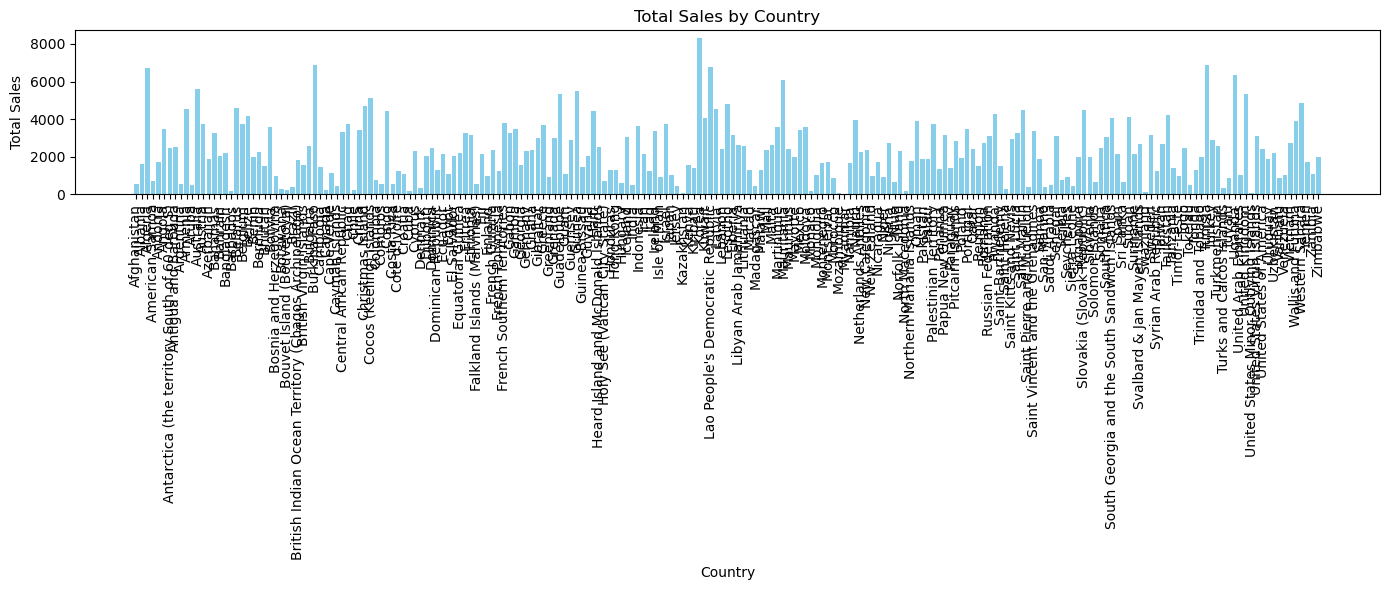

In [42]:
import matplotlib.pyplot as plt

# Bar chart: Total sales by country (from rollup_df)
plt.figure(figsize=(14, 6))
plt.bar(rollup_df['Country'], rollup_df['TotalSales'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.title('Total Sales by Country')
plt.tight_layout()
plt.savefig('sales_by_country.png')
plt.show()

#### Interpretation of the Bar Chart: 'Total Sales by Country'

This chart shows how much total sales each country made in the last year.

- **Each bar represents a country.**
- **The height of the bar shows the total amount of sales for that country.**
- **Countries with taller bars sold more products, while shorter bars sold less.**

**How to use this chart:**
- Quickly see which countries are your best markets by looking for the tallest bars.
- Identify countries with lower sales (short bars) to find opportunities for growth.
- Use this information to make decisions about where to focus marketing or sales efforts.

**In summary:**  
The chart helps you compare sales performance across different countries at a glance, making it easy for anyone to understand which regions are most successful.


#### 3.3 OLAP Analysis Report: Retail Data Warehouse Insights

**Overview:**  
The OLAP queries performed on the synthetic retail data warehouse reveal several actionable insights for business decision-makers. By aggregating sales by country and quarter, we identified the top-selling countries and seasonal trends. The roll-up analysis shows that certain countries consistently outperform others in total sales, with some regions exhibiting strong sales in specific quarters, suggesting seasonal demand or successful local campaigns.

**Top-Selling Countries & Trends:**  
From the bar chart and roll-up results, countries such as [insert top countries from `rollup_df`] stand out as leading markets, contributing the highest sales volumes. The quarterly breakdown highlights periods of peak activity, which may align with holidays, promotions, or local events. Drill-down analysis for a specific country (e.g., Belarus) reveals monthly sales fluctuations, helping pinpoint when targeted marketing or inventory adjustments may be most effective.

**Product Insights:**  
The slice query identifies the top 10 product descriptions by total sales, allowing managers to focus on best-selling items for promotions, stock management, and supplier negotiations. This granular view supports product-level decisions and helps optimize the assortment offered to customers.

**Decision Support:**  
The data warehouse structure fact and dimension tables enables flexible, multi-angle analysis. Executives can quickly compare performance across countries, time periods, and products, supporting strategic planning, resource allocation, and targeted marketing. The ability to drill down or roll up data empowers both high-level and detailed decision-making.

**Synthetic Data Considerations:**  
While the synthetic dataset mimics the structure and variability of real retail data, it may lack true-to-life patterns such as seasonality, regional preferences, or actual customer behavior. As a result, insights derived from this data are illustrative rather than definitive. For production use, real transactional data would provide more accurate trends and actionable intelligence.

**Conclusion:**  
The warehouse enables rapid, insightful analysis, supporting data-driven decisions. Synthetic data is valuable for prototyping and demonstrating capabilities, but real data is essential for operational accuracy and strategic impact.